In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

frequencySelectionApplied = 0    # 0 = do not apply, 1 = do apply

data = pd.read_csv("synthetic_data_lung_cancer.csv")

if frequencySelectionApplied == 1:
    data = pd.read_csv("data/bestFrequencyFiltered_t-low-0.3_t-high-1.csv")

print(data.columns)
data.tail()

Index(['SUBJECT_ID', 'DEFINITION_ID', 'TIME'], dtype='object')


,SUBJECT_ID,DEFINITION_ID,TIME
560966,984,measurement_1141,0.027321
560967,984,observation_156,0.028739
560968,984,measurement_1140,0.030802
560969,984,measurement_1327,0.035081
560970,984,condition_459,0.038022


In [15]:
data.loc[data['DEFINITION_ID'].str.contains('condition_*')]

#all condition observations are removed due to frequency Filtering

,SUBJECT_ID,DEFINITION_ID,TIME
1,1,condition_1922,0.008643
2,1,condition_785,0.027792
5,1,condition_1561,0.057292
7,1,condition_2391,0.065500
8,1,condition_175,0.166536
...,...,...,...
560922,984,condition_747,0.006456
560923,984,condition_1767,0.007445
560931,984,condition_517,0.008754
560964,984,condition_1496,0.023802


In [16]:
dataFormat = 1 # 0 for seperate ID column 1 for not
df = data.copy()
if dataFormat == 0:
    label_encoder = LabelEncoder()
    df['DEFINITION_ID_encoded'] = label_encoder.fit_transform(df['DEFINITION_ID'])
    df['condition'] = df['DEFINITION_ID'].apply(lambda x: 'condition' in x)
    df['procedure'] = df['DEFINITION_ID'].apply(lambda x: 'procedure' in x)
    df['drug'] = df['DEFINITION_ID'].apply(lambda x: 'drug' in x)
    df['observation'] = df['DEFINITION_ID'].apply(lambda x: 'observation' in x)
    df['measurement'] = df['DEFINITION_ID'].apply(lambda x: 'measurement' in x)
    df.drop(columns=['DEFINITION_ID'], inplace=True)
    df['time_since_last'] = df.groupby('SUBJECT_ID')['TIME'].diff().fillna(0)
    columns_to_convert = ['condition', 'procedure', 'drug', 'observation', 'measurement']
    for column in columns_to_convert:
        df[column] = df[column].astype(int)
    time_threshold = 1
    df['DEATH'] = df['time_since_last'].apply(lambda x: 1 if x <= time_threshold else 0)
elif dataFormat == 1:
    # Splitting 'DEFINITION_ID' into multiple columns
    new_cols = df['DEFINITION_ID'].str.split('_', expand=True)
    # Naming the new columns
    new_cols.columns = ['CATEGORY', 'CATEGORY_ID']
    print("New unique categorie: "+new_cols['CATEGORY'].unique())
    # Pivoting the DataFrame
    pivot_new_cols = new_cols.pivot_table(index=data.index, columns='CATEGORY', values='CATEGORY_ID', aggfunc=lambda x: ', '.join(str(v) for v in x)).fillna('-1')
    # Concatenating the new columns to the original DataFrame
    df = pd.concat([df, pivot_new_cols], axis=1)
    # Dropping the original 'DEFINITION_ID' column
    df.drop(columns=['DEFINITION_ID'], inplace=True)
    # Filling the death column
    df['death'] = df['death'].replace('None', '1')
    df['death'] = df['death'].replace('-1', '0')
    # Converting column to boolean dtype
    df['death'] = df['death'].astype(int)
    # Creating additional column
    df['time_since_last'] = df.groupby('SUBJECT_ID')['TIME'].diff().fillna(0)
else:
    ...

print(df.columns)
#df.loc[(df['condition']=='')&(df['drug']=='')&(df['measurement']=='')&(df['observation']=='')&(df['procedure']=='')]
[print("Unique values in feature "+x+": "+str(len(df[x].unique()))) for x in df.columns]

df.head()

['New unique categorie: drug' 'New unique categorie: condition'
 'New unique categorie: measurement' 'New unique categorie: observation'
 'New unique categorie: procedure' 'New unique categorie: death']
Index(['SUBJECT_ID', 'TIME', 'condition', 'death', 'drug', 'measurement',
       'observation', 'procedure', 'time_since_last'],
      dtype='object')
Unique values in feature SUBJECT_ID: 727
Unique values in feature TIME: 560956
Unique values in feature condition: 2400
Unique values in feature death: 2
Unique values in feature drug: 419
Unique values in feature measurement: 1333
Unique values in feature observation: 225
Unique values in feature procedure: 491
Unique values in feature time_since_last: 560198


,SUBJECT_ID,TIME,condition,death,drug,measurement,observation,procedure,time_since_last
0,1,0.004807,-1,0,217,-1,-1,-1,0.000000
1,1,0.008643,1922,0,-1,-1,-1,-1,0.003836
2,1,0.027792,785,0,-1,-1,-1,-1,0.019149
3,1,0.032515,-1,0,49,-1,-1,-1,0.004722
4,1,0.056765,-1,0,-1,132,-1,-1,0.024250


In [17]:
#dummies for categorical analysis

createDummies = 0 # 0 = no, 1 = yes

if createDummies ==1 and dataFormat==1:
    df = pd.get_dummies(df,columns=['condition','drug','measurement','observation','procedure'])

df.head()

,SUBJECT_ID,TIME,condition,death,drug,measurement,observation,procedure,time_since_last
0,1,0.004807,-1,0,217,-1,-1,-1,0.000000
1,1,0.008643,1922,0,-1,-1,-1,-1,0.003836
2,1,0.027792,785,0,-1,-1,-1,-1,0.019149
3,1,0.032515,-1,0,49,-1,-1,-1,0.004722
4,1,0.056765,-1,0,-1,132,-1,-1,0.024250


In [18]:
from sklearn.model_selection import train_test_split

# List of unique SUBJECT_IDs
unique_subject_ids = df['SUBJECT_ID'].unique()

# Split the unique_subject_ids into train and test IDs
train_ids, test_ids = train_test_split(unique_subject_ids, test_size=0.3, random_state=2)

# Filter the main DataFrame into train and test sets based on the selected IDs
train_data = df[df['SUBJECT_ID'].isin(train_ids)]
test_data = df[df['SUBJECT_ID'].isin(test_ids)]

# Separate the features (X) and target variable (y) for train and test sets
X_train = train_data.drop('death',axis=1)# Drop 'SUBJECT_ID' and target column
y_train = pd.Series(train_data.death)

X_test = test_data.drop('death',axis=1)# Drop 'SUBJECT_ID' and target column
y_test = pd.Series(test_data.death)

if createDummies ==1 and dataFormat==1:
    X_train = X_train.drop(['condition_-1','drug_-1','measurement_-1','observation_-1','procedure_-1'],axis=1)
    X_test = X_test.drop(['condition_-1','drug_-1','measurement_-1','observation_-1','procedure_-1'],axis=1)
#old way:
#X = df.drop('death',axis=1).drop(['condition_-1','drug_-1','measurement_-1','observation_-1','procedure_-1'],axis=1)
#y = pd.Series(df.death)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print(y_train.head())
X_train.head()

0    0
1    0
2    0
3    0
4    0
Name: death, dtype: int64


,SUBJECT_ID,TIME,condition,drug,measurement,observation,procedure,time_since_last
0,1,0.004807,-1,217,-1,-1,-1,0.000000
1,1,0.008643,1922,-1,-1,-1,-1,0.003836
2,1,0.027792,785,-1,-1,-1,-1,0.019149
3,1,0.032515,-1,49,-1,-1,-1,0.004722
4,1,0.056765,-1,-1,132,-1,-1,0.024250


In [19]:
#undersampling

from sklearn.utils import resample

useUnderSampeling = 0 # 0 = no, 1 = yes

if useUnderSampeling == 1:
    # Separate majority and minority classes
    df_majority = df[df.death==0]
    df_minority = df[df.death==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority,
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority), # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_balanced.death.value_counts())
    print([len(df_balanced.loc[df_balanced['death']==1]),len(df_balanced.loc[df_balanced['death']==0, 'SUBJECT_ID'].unique())])

    # Separate X_train and y_train after balancing
    X_train_balanced = df_balanced.drop('death', axis=1)
    y_train_balanced = df_balanced['death']
    X_train = X_train_balanced
    y_train = y_train_balanced
else:
    print("Nothing happened")

Nothing happened


In [20]:
#feature selection

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression  # Replace with an appropriate estimator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.sparse import csr_matrix


if createDummies==1:

#X_train_sparse = csr_matrix(X_train)

    # Initialize your estimator
    lr=LogisticRegression(penalty='l1',solver='liblinear')
    svc=SVC(kernel="linear")
    nb=GaussianNB()

    estimator = lr  #change to whatever works best

    # Initialize RFECV with the estimator and scoring method
    rfecv=RFECV(estimator=estimator, cv=5)
    kbest=SelectKBest(score_func=f_classif, k=1000)
    selector = kbest

    # Fit the selector on your training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    # Get selected feature indices
    selected_feature_indices = selector.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = X_train.columns[selected_feature_indices]

    # Create DataFrame with selected features
    X_train_selected_df = X_train[selected_feature_names]

    print(X_train_selected_df.head())
else:
    print("No feature selection, because of low feature count")

No feature selection, because of low feature count


In [21]:
# no scaling necessary

In [22]:
#!pip install prince

In [23]:
from prince import MCA
from sklearn.decomposition import PCA
#pip install prince

#applying MCA,PCA or others

def applyDimensionalityReduction(reductionTargetTrain,reductionTargetTest,typeOfReduction,n_components):
    if typeOfReduction == 'mca':
        X_train_categorical = reductionTargetTrain.drop(columns=['TIME','time_since_last'], inplace=False)
        X_test_categorical = reductionTargetTest.drop(columns=['TIME','time_since_last'], inplace=False)
        reducer = MCA(n_components=n_components)
        reducer.fit(X_train_categorical)
        transformed_train = reducer.transform(X_train_categorical)
        transformed_test = reducer.transform(X_test_categorical)
        X_train_mca = pd.concat([reductionTarget[['TIME','time_since_last']],transformed_train],axis=1)
        X_test_mca = pd.concat([reductionTarget[['TIME','time_since_last']],transformed_test],axis=1)
        return X_train_mca,X_test_mca
    elif typeOfReduction =='pca':
        reductionTargetTrain.columns = reductionTargetTrain.columns.astype(str)
        reductionTargetTest.columns = reductionTargetTest.columns.astype(str)
        reducer = PCA(n_components=n_components)
        reducer.fit(reductionTargetTrain)
        transformed_train = reducer.transform(reductionTargetTrain)
        transformed_test = reducer.transform(reductionTargetTest)
        return pd.DataFrame(transformed_train), pd.DataFrame(transformed_test)
    else:
        return X_train,X_test

In [24]:
X_train_reduced,X_test_reduced = applyDimensionalityReduction(X_train,X_test,'pca',4) # choose 'mca','pca' or 'None'

if 1:
    X_train = X_train_reduced
    X_test = X_test_reduced
X_train.head()

,0,1,2,3
0,-137.620248,-401.580999,-493.039637,-136.075297
1,1649.627537,319.679942,-493.285448,-0.027705
2,593.788644,-99.598326,-493.306256,-3.267159
3,-136.452734,-392.226487,-493.256190,-35.453526
4,-185.432370,-266.327453,-492.576405,-4.816040


# AdaBoost

In [25]:
from sklearn.ensemble import AdaBoostClassifier

# Your existing RandomForestClassifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create an AdaBoostClassifier
ada_boost_classifier = AdaBoostClassifier(base_estimator=rf_classifier, n_estimators=50, random_state=42)

# Fit AdaBoostClassifier
ada_boost_classifier.fit(X_train_reduced, y_train)

# Predict using AdaBoostClassifier
y_pred_ada = ada_boost_classifier.predict(X_test_reduced)

# Classification Report for AdaBoostClassifier
print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_ada))

# AUC Score for AdaBoostClassifier
auc_score_ada = roc_auc_score(y_test, y_pred_ada)
print(f"AdaBoost AUC Score: {auc_score_ada}")

# AdaBoost AUC Score: 0.905

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153324
           1       0.97      0.81      0.88        84

    accuracy                           1.00    153408
   macro avg       0.99      0.90      0.94    153408
weighted avg       1.00      1.00      1.00    153408

AdaBoost AUC Score: 0.9047553826257747


# XGBoost

In [27]:
import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_reduced, label=y_train)
dtest = xgb.DMatrix(X_test_reduced, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(dtest)

# Convert probabilities to binary classification
y_pred_xgb_binary = (y_pred_xgb > 0.5).astype(int)

# Classification Report for XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_binary))

# AUC Score for XGBoost
auc_score_xgb = roc_auc_score(y_test, y_pred_xgb_binary)
print(f"XGBoost AUC Score: {auc_score_xgb}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:36:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153324
           1       0.71      0.30      0.42        84

    accuracy                           1.00    153408
   macro avg       0.86      0.65      0.71    153408
weighted avg       1.00      1.00      1.00    153408

XGBoost AUC Score: 0.6487769131288738


# XGBoost hyperparameter tuning with GridSearch

In [ ]:
# hyperparameter tuning

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.3, 0.7, 1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
grid_search.fit(X_train_reduced, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_best = best_model.predict(X_test_reduced)

# Classification Report for the best model
print("Best XGBoost Model Classification Report:")
print(classification_report(y_test, y_pred_best))

# AUC Score for the best model
auc_score_best = roc_auc_score(y_test, y_pred_best)
print(f"Best XGBoost Model AUC Score: {auc_score_best}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=   0.4s
[CV] END colsample_by

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# model
rf = RandomForestClassifier(n_estimators=50,criterion="gini",max_features=100,max_depth=4)
svc = SVC(kernel="linear", probability=True)
model = rf # select desired model

#fit model
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, max_features=100, n_estimators=50)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)#, shuffle=True, random_state=42

#cross validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
print(scores)

[0.35454099 0.98888589 0.98052187 0.85363788 0.99223726]


In [ ]:
#predict probabilities
probs = model.predict_proba(X_test)
probs = pd.DataFrame(probs)
y_pred_proba = pd.Series(probs.iloc[:, 1])

# Calculate AUC
auc = roc_auc_score(y_test.values, y_pred_proba)
print("AUC:", auc)

AUC: 0.9711239410846126


ROC AUC Score: 0.97


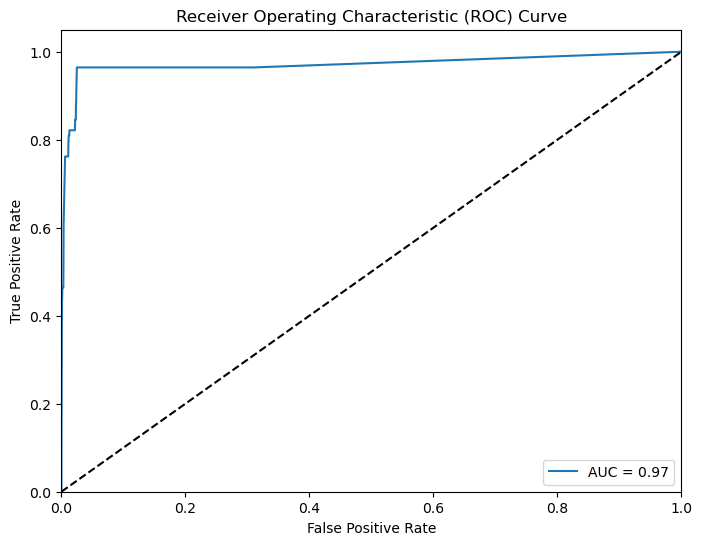

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print(f"ROC AUC Score: {auc:.2f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()